# Explore here

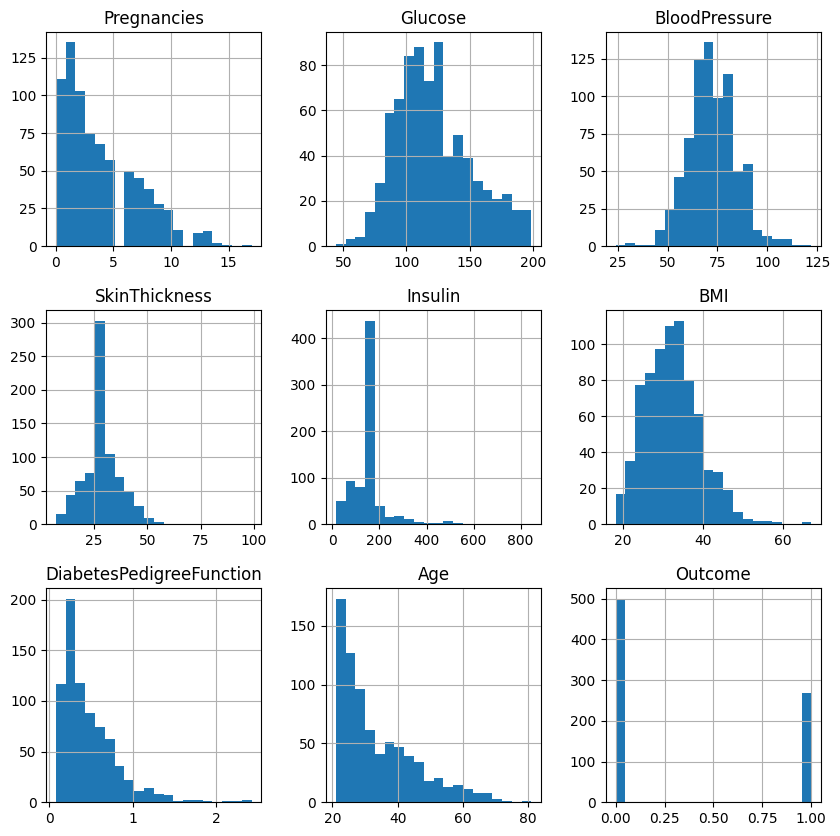

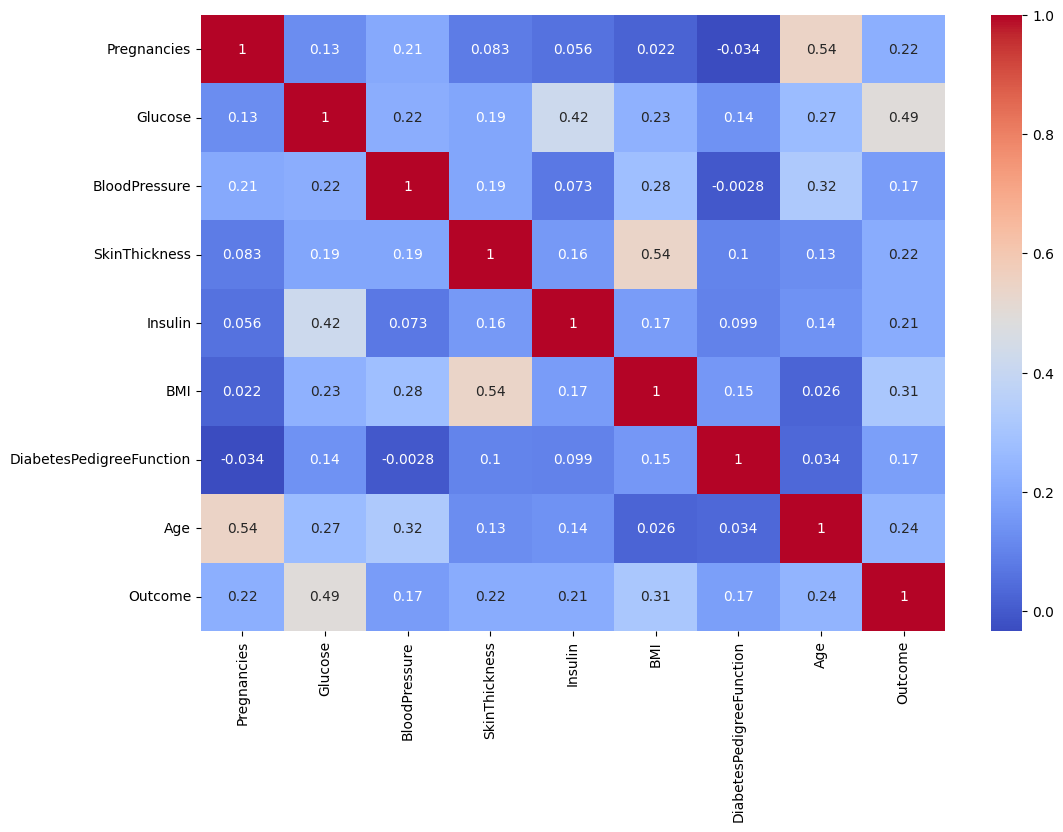

Accuracy: 0.6796536796536796
ROC AUC Score: 0.6511111111111111
F1 Score: 0.5487804878048781
Precision: 0.5421686746987951
Recall: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       150
           1       0.54      0.56      0.55        81

    accuracy                           0.68       231
   macro avg       0.65      0.65      0.65       231
weighted avg       0.68      0.68      0.68       231

[[112  38]
 [ 36  45]]
Best Accuracy: 0.7316017316017316
Best ROC AUC Score: 0.8
Best F1 Score: 0.5866666666666667
Best Precision: 0.6376811594202898
Best Recall: 0.5432098765432098
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       150
           1       0.64      0.54      0.59        81

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.69       231
weighted avg       0.72      0.73      0.73       231

[[125  25]
 [ 3

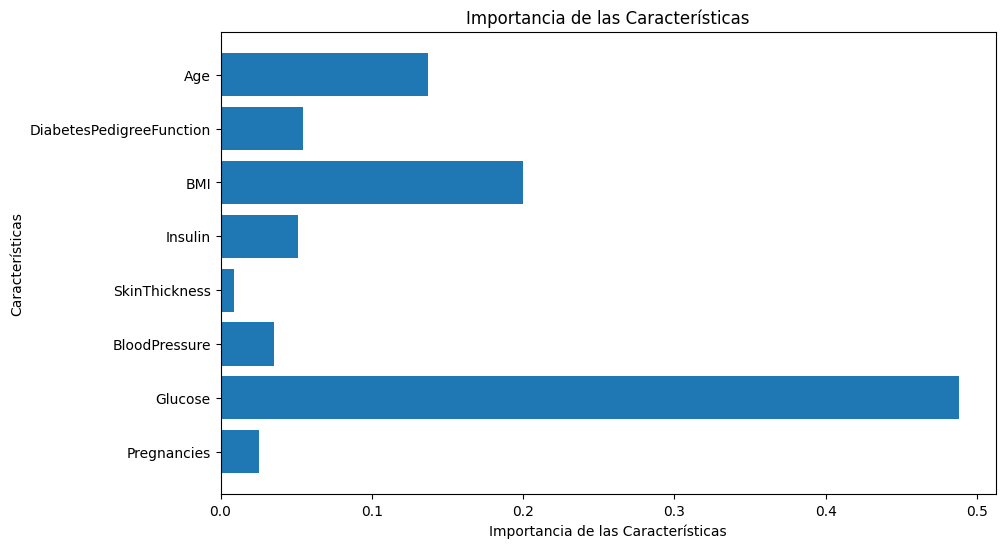

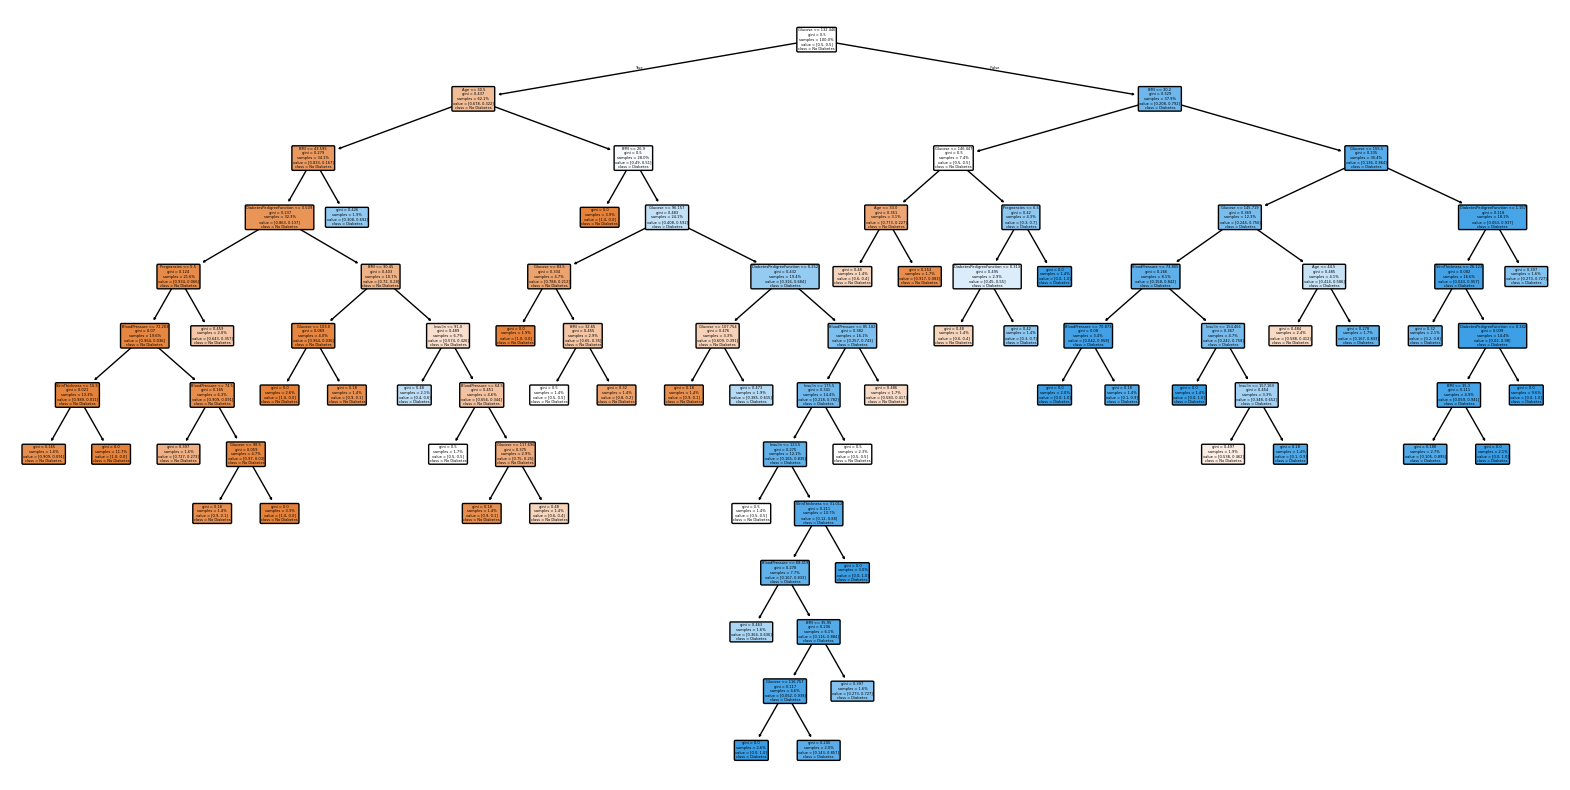

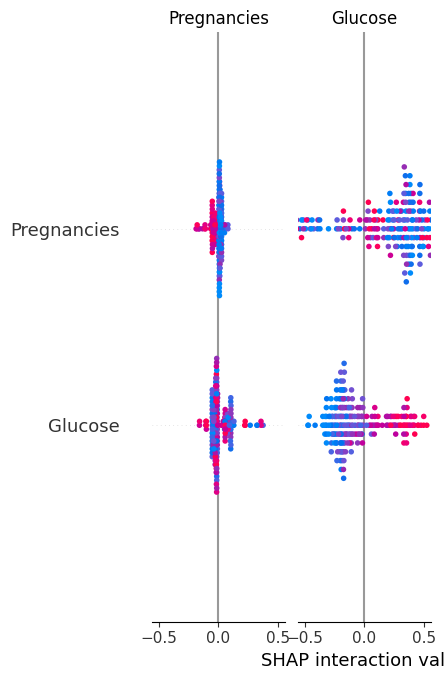

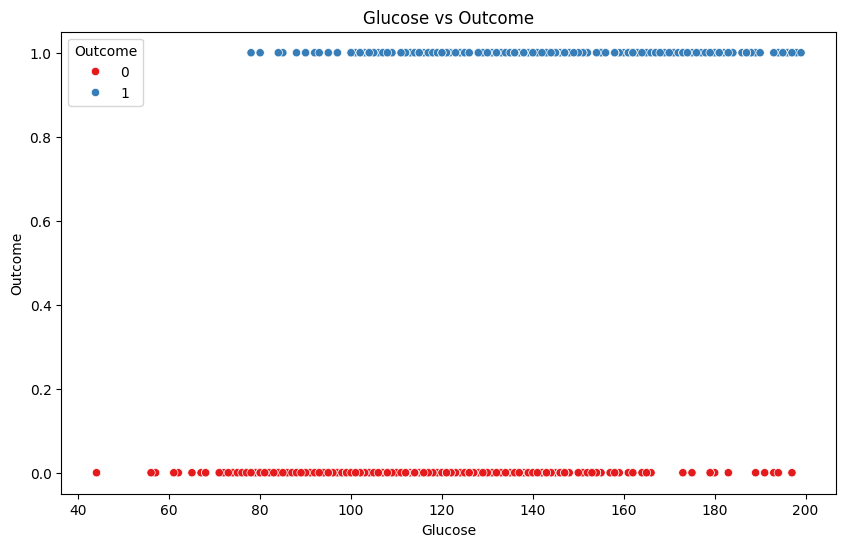

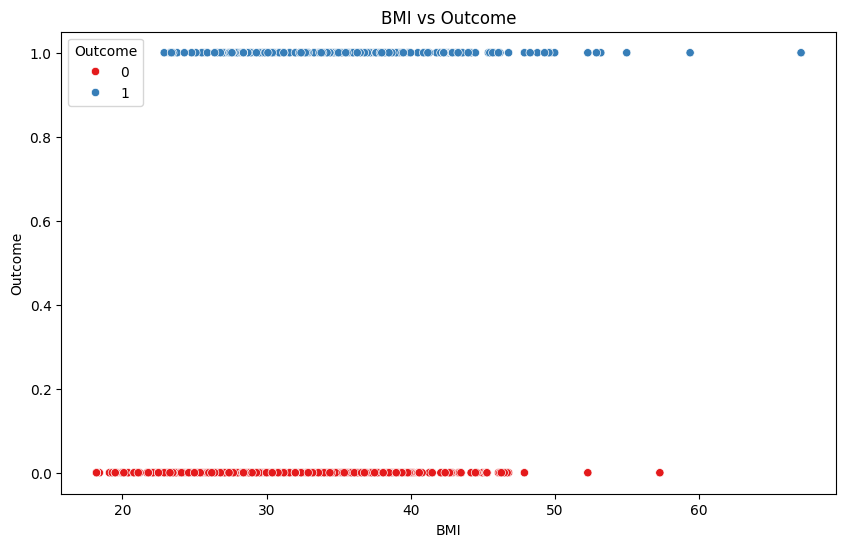

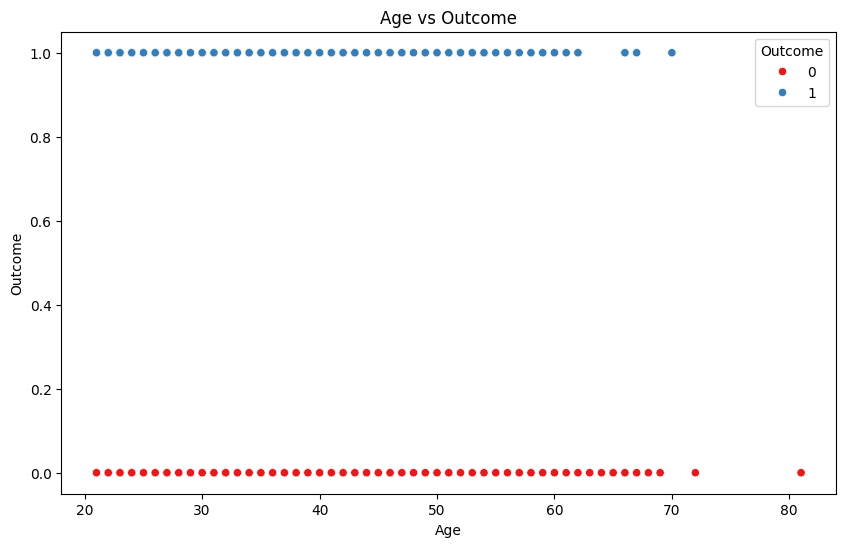

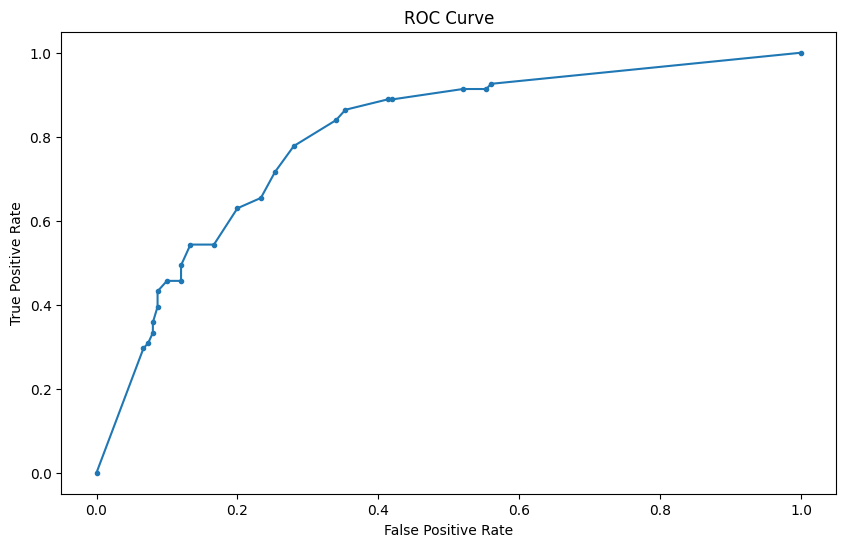

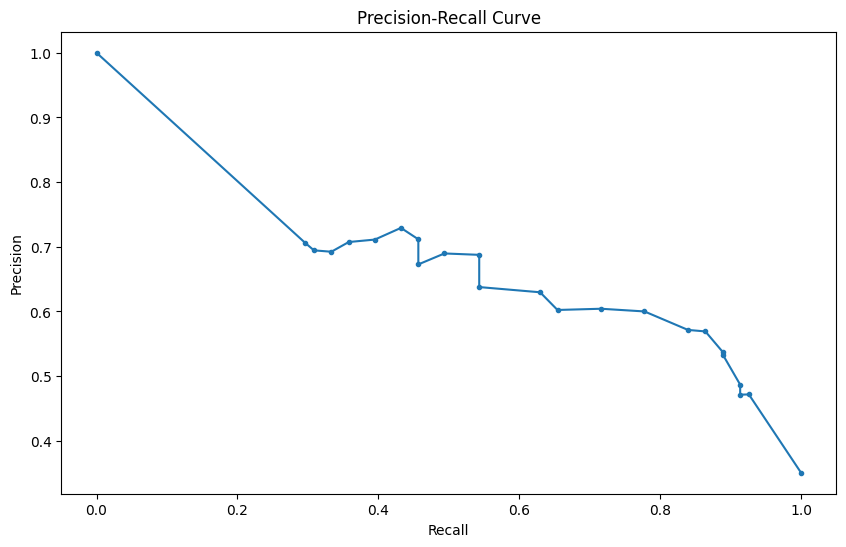

In [21]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
import joblib
import shap

# Cargar el conjunto de datos desde la URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(url)

# Análisis Exploratorio de Datos (EDA)
# Reemplazar 0 por NaN en columnas específicas
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
df[columns_to_replace] = imputer.fit_transform(df[columns_to_replace])

# Visualizar distribuciones después de la imputación
df.hist(bins=20, figsize=(10, 10))
plt.show()

# Correlación entre características
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Separar características y la variable objetivo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en conjuntos de entrenamiento y prueba de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Aplicar SMOTE para balancear el dataset de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Construir el modelo de árbol de decisión con datos balanceados
clf_smote = DecisionTreeClassifier(random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

# Predicciones
y_pred_smote = clf_smote.predict(X_test)
y_pred_smote_proba = clf_smote.predict_proba(X_test)[:, 1]

# Evaluar el modelo con datos balanceados
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_smote_proba))
print("F1 Score:", f1_score(y_test, y_pred_smote))
print("Precision:", precision_score(y_test, y_pred_smote))
print("Recall:", recall_score(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print(confusion_matrix(y_test, y_pred_smote))

# Optimización del Modelo
# Definir los parámetros a optimizar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=clf_smote, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Mejor modelo encontrado
best_clf = grid_search.best_estimator_

# Evaluar el mejor modelo
y_pred_best = best_clf.predict(X_test)
y_pred_best_proba = best_clf.predict_proba(X_test)[:, 1]
print("Best Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best ROC AUC Score:", roc_auc_score(y_test, y_pred_best_proba))
print("Best F1 Score:", f1_score(y_test, y_pred_best))
print("Best Precision:", precision_score(y_test, y_pred_best))
print("Best Recall:", recall_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

# Guardar el modelo
joblib.dump(best_clf, 'best_decision_tree_model.pkl')

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(X.columns, best_clf.feature_importances_)
plt.xlabel('Importancia de las Características')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.show()

# Visualización del árbol de decisión con colores
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], rounded=True, proportion=True)
plt.show()

# Crear un explicador SHAP
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test)

# Visualización de los valores SHAP
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)
else:
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Visualizaciones adicionales
# Gráfico de puntos para analizar la relación entre las características y el resultado
features_to_plot = ['Glucose', 'BMI', 'Age']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[feature], y=df['Outcome'], hue=df['Outcome'], palette='Set1')
    plt.title(f'{feature} vs Outcome')
    plt.xlabel(feature)
    plt.ylabel('Outcome')
    plt.show()

# Curva ROC y curva Precision-Recall
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_best_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_best_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()